# Bins on the sphere

In [353]:
import matplotlib.pyplot as plt
%matplotlib inline

(768, 1024, 3)


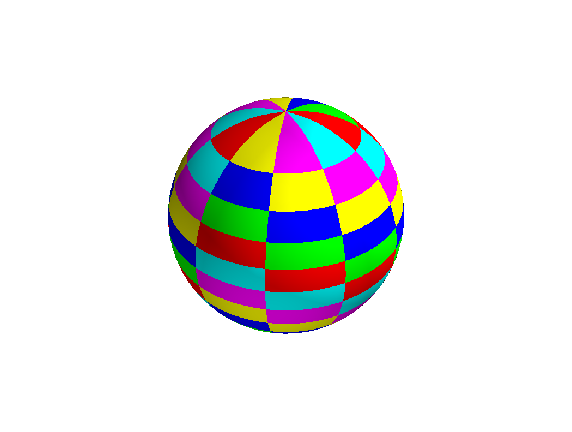

In [50]:
from mayavi import mlab

import pylab as pl

def mlab_show():
    arr = mlab.screenshot()
    print(arr.shape)
    pl.figure(figsize=(10,10))
    pl.imshow(arr)
    pl.axis('off')
    pl.show()

%matplotlib inline

#mlab.init_notebook(backend='ipy')

import numpy as np

# Create a sphere
#r = 1.0
#pi = np.pi
#cos = np.cos
#sin = np.sin
#phi, theta = np.mgrid[0:pi:101j, 0:2 * pi:101j]

#x = r*sin(phi)*cos(theta)
#y = r*sin(phi)*sin(theta)
#z = r*cos(phi)

#mlab.figure(bgcolor=(1, 1, 1), fgcolor=(0, 0, 0), size=(1024, 768))
#mlab.clf()

def uniform_on_sphere(n):
    x = np.random.randn(n, 3)
    x = x / np.sqrt((x ** 2).sum(axis=1))[:,np.newaxis]
    return x

data = uniform_on_sphere(1000)



#mlab.mesh(x , y , z, color=(0.0,0.5,1.0), line_width=0.1)
#mlab.points3d(data[:,0], data[:,1], data[:,2], scale_factor=0.05)

mlab.figure(bgcolor=(1, 1, 1), fgcolor=(0, 0, 0), size=(1024, 768))

bright_colors = [
    (1, 0, 0),
    (0, 1, 0),
    (0, 0, 1),
    (1, 1, 0),
    (1, 0, 1),
    (0, 1, 1)
]

steps = 10
step_points = 10
for u in range(steps):
    for v in range(steps):
        ug = np.linspace(u / steps, (u + 1) / steps, step_points)
        vg = np.linspace(v / steps, (v + 1) / steps, step_points)
        
        ug, vg = np.meshgrid(ug, vg)
        
        # θ=2πu
        # ϕ=arccos(2v−1)
        
        theta = 2 * np.pi * ug
        phi = np.arccos(2 * vg - 1)
        
        r = 1.0
        x = r*np.sin(phi)*np.cos(theta)
        y = r*np.sin(phi)*np.sin(theta)
        z = r * np.cos(phi)
        
        #print(x.shape, y.shape, z.shape)
        
        mlab.mesh(x, y, z, color=bright_colors[(u + v) % len(bright_colors)], line_width=0.1)


mlab_show()

In [123]:
x = uniform_on_sphere(10000)

In [124]:
def cartesian_to_spherical(x):
    # x = r*np.sin(phi)*np.cos(theta)
    # y = r*np.sin(phi)*np.sin(theta)
    # z = r * np.cos(phi)
    
    r = 1.0
    phi = np.arccos(x[:,2] / r)
    theta = np.arctan2(x[:,0], x[:,1])
    
    return phi, theta



In [249]:
def map_to_square(phi, theta):
    assert phi.max() <= np.pi + 1e-3
    assert phi.min() >= -1e-3
    
    u = theta / (2 * np.pi)
    v = (np.cos(phi) + 1) / 2
    u[u < 0] += 1
    u[u > 1] -= 1
    v[v < 0] += 1
    v[v > 1] -= 1
    return u, v

def map_to_bins(u, v, bins_per_axis):
    ub = np.clip(np.floor(u * bins_per_axis).astype(np.uint32), 0, bins_per_axis - 1)
    vb = np.clip(np.floor(v * bins_per_axis).astype(np.uint32), 0, bins_per_axis - 1)
    
    bin_idx = ub * bins_per_axis + vb
    #print(bin_idx)
    bin_counts = np.bincount(bin_idx.flatten())
    #print(bin_counts)
    assert len(bin_counts) <= bins_per_axis * bins_per_axis
    assert np.sum(bin_counts) == len(u)
    bin_counts = np.pad(bin_counts, (0, bins_per_axis * bins_per_axis - len(bin_counts)))
    return bin_counts

In [250]:
bins = map_to_bins(u, v, 10)

In [251]:
def uniformity_chi_stat(bins):
    num_obs = np.sum(bins)
    expected = num_obs / len(bins)
    #print('expected per bin', expected)
    return np.sum((bins - expected) ** 2 / expected), len(bins) - 1

In [252]:
def non_uniform_on_sphere(n):
    phi = np.random.uniform(0, np.pi, n)
    theta = np.random.uniform(0, np.pi * 2, n)
    # x = r*np.sin(phi)*np.cos(theta)
    # y = r*np.sin(phi)*np.sin(theta)
    # z = r * np.cos(phi)
    res = np.zeros(shape=(n, 3))
    res[:,0] = np.sin(phi) * np.cos(theta)
    res[:,1] = np.sin(phi) * np.sin(theta)
    res[:,2] = np.cos(phi)
    #print(res)
    return res

In [253]:
from scipy.stats import chi2
import scipy.stats

def do_test(verbose):
    x = non_uniform_on_sphere(200)
    phi, theta = cartesian_to_spherical(x)
    u, v = map_to_square(phi, theta)
    bins = map_to_bins(u, v, 7)
    chi_stat, dof = uniformity_chi_stat(bins)
    if verbose:
        print(bins)
        print(chi_stat)

    # probability of failure when rejecting the null hypothesis 'it is uniform' when it is true
    p_value = 1 - chi2.cdf(chi_stat, dof)
    if verbose:
        print('p-value (~ probability is uniform):', p_value)
        print(scipy.stats.chisquare(bins))
        print()

    print('is uniform (strict):', ('yes' if p_value > 0.01 else 'no'))
    
do_test(True)

for i in range(20):
    do_test(False)

[ 8  0  5  1  6  3  4 12  3  3  4  2  2  5  8  3  0  3  2  3  8 10  3  4
  2  2  2  6  8  1  5  2  5  4  5  8  0  2  6  1  2 11  6  4  4  1  3  3
  5]
93.02
p-value (~ probability is uniform): 0.00010540768488087604
Power_divergenceResult(statistic=93.02, pvalue=0.00010540768488089069)

is uniform (strict): no
is uniform (strict): yes
is uniform (strict): no
is uniform (strict): no
is uniform (strict): yes
is uniform (strict): no
is uniform (strict): no
is uniform (strict): yes
is uniform (strict): no
is uniform (strict): no
is uniform (strict): no
is uniform (strict): no
is uniform (strict): no
is uniform (strict): no
is uniform (strict): no
is uniform (strict): yes
is uniform (strict): no
is uniform (strict): no
is uniform (strict): no
is uniform (strict): no
is uniform (strict): no


# Reference uniform distribution

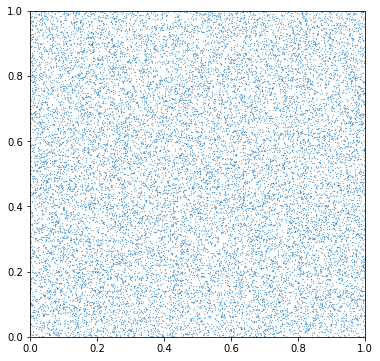

In [349]:
n = 20000
x = uniform_on_sphere(n)
phi, theta = cartesian_to_spherical(x)
u, v = map_to_square(phi, theta)
plot_square(u, v)

# Reference non-uniform distribution (($\psi, \theta$)-uniform)

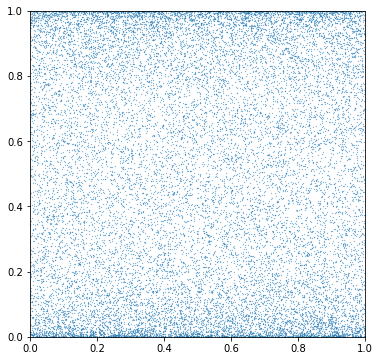

In [352]:
x = non_uniform_on_sphere(20000)
phi, theta = cartesian_to_spherical(x)
u, v = map_to_square(phi, theta)

plot_square(u, v)


# Real distribution plots

In [244]:
import os
import array

data_path = './korp_stats.bin'
double_size = 8

n_nums = int(os.path.getsize(data_path)/double_size)
n_content = 5
if n_nums % n_content != 0:
    print("Oops, something went wrong with the file size and contents.")
n_entries = int(n_nums/n_content)
F = open(data_path, 'rb')
data = array.array('d')
data.fromfile(F, n_nums)
F.close()
data = np.array(data)
data = np.reshape(data, (n_entries, n_content))
print(np.shape(data))

(47916041, 5)


In [247]:
data[:5]

array([[10.        , 13.        , 18.35012272,  2.84635897,  3.58099849],
       [11.        , 13.        , 19.58776331,  0.94729078,  2.65130192],
       [ 1.        , 13.        , 16.27541755,  2.57432665,  2.69985052],
       [14.        , 13.        , 16.11988392,  1.16478043,  4.83862683],
       [10.        , 13.        , 12.37842154,  1.00788748,  2.3572276 ]])

0. protein residue type (it was originally an int)

1.  ligand atom type (it was originally an int) 

2. distance

3. theta angle (between the vector and Z, 0-pi)

4. psi angle (between the vector projection and X, 0-2pi)


In [279]:
data_local = data[np.where((data[:, 0] == 0.) & (data[:, 1] == 4.))][:, 2:]

In [300]:
def plot_square(u, v):
    plt.figure(figsize=(6,6))
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.scatter(u, v, s=1000.0 / len(u))
    plt.show()


In [354]:
def plot_for_distance_range(data, d_min, d_max):
    data_local = data[np.where(
        (data[:, 2] > d_min) & (data[:, 2] <= d_max))
    ][:, 3:]
    
    #print(data_local.shape[0])
    if data_local.shape[0] < 10:
        return
        
    u, v = map_to_square(data_local[:,0], data_local[:,1])
    bins = map_to_bins(u, v, 3)
    #print(bins)
    chi_stat, dof = uniformity_chi_stat(bins)

    #p_value = 1 - chi2.cdf(chi_stat, dof)
    
    p_value = scipy.stats.chisquare(bins).pvalue
    print('Distance ({};{}]:'.format(d_min, d_max), '{} values'.format(np.sum(bins)), 'bins', bins, 'p-value', p_value)
    #print('p-value (~ probability is uniform):', p_value)
    #print(scipy.stats.chisquare(bins))
    #print()
    #print('is uniform (strict):', ('yes' if p_value > 0.01 else 'no'))

    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.text(0.1, 0.85, '({},{}]'.format(d_min, d_max), color='fuchsia', fontsize=20)
    plt.scatter(u, v, s=1000.0 / len(u))
    
def plot_for_pair(a, b):
    plt.figure(figsize=(15, 15))
    sub_data = data[np.where(
            (data[:, 0] == a) &
            (data[:, 1] == b))
        ][:,:]
    print('Got', sub_data.shape[0], 'values of', data.shape[0], 'for pair', a, '-', b)
    for d in range(2, 20):
        plt.subplot(5, 4, 1 + d)
        plot_for_distance_range(sub_data, d, d + 1)
    plt.show()
    
    #plot_square(u, v)
    
#plot_for_distance_range(0, 0, 1, 4)
#plot_for_distance_range(0, 0, 4, 10)
#plot_for_distance_range(0, 0, 10, 20)

# Pair 0 - 0

Got 687016 values of 47916041 for pair 0 - 0
Distance (3;4]: 1030 values bins [509 157  31 299   9   0  16   6   3] p-value 0.0
Distance (4;5]: 6283 values bins [1617  390  177 1644  583   72 1147  442  211] p-value 0.0
Distance (5;6]: 10863 values bins [1432  872  314 1746 1333  422 3322 1013  409] p-value 0.0
Distance (6;7]: 13758 values bins [1809 1625  716 2004 1539  684 3367 1288  726] p-value 0.0
Distance (7;8]: 18457 values bins [2529 2016 1878 2372 1701 1096 3692 1621 1552] p-value 0.0
Distance (8;9]: 24424 values bins [2440 2930 2901 2615 2160 1900 4774 2357 2347] p-value 0.0
Distance (9;10]: 32468 values bins [2773 3910 4011 2936 3290 2681 5751 3844 3272] p-value 0.0
Distance (10;11]: 40460 values bins [3274 4394 4837 3843 4122 3343 6368 5530 4749] p-value 0.0
Distance (11;12]: 44812 values bins [3697 4406 5404 4594 3868 3751 6012 6162 6918] p-value 0.0
Distance (12;13]: 50322 values bins [4105 5092 5617 5288 3998 5217 6161 6827 8017] p-value 0.0
Distance (13;14]: 53874 value

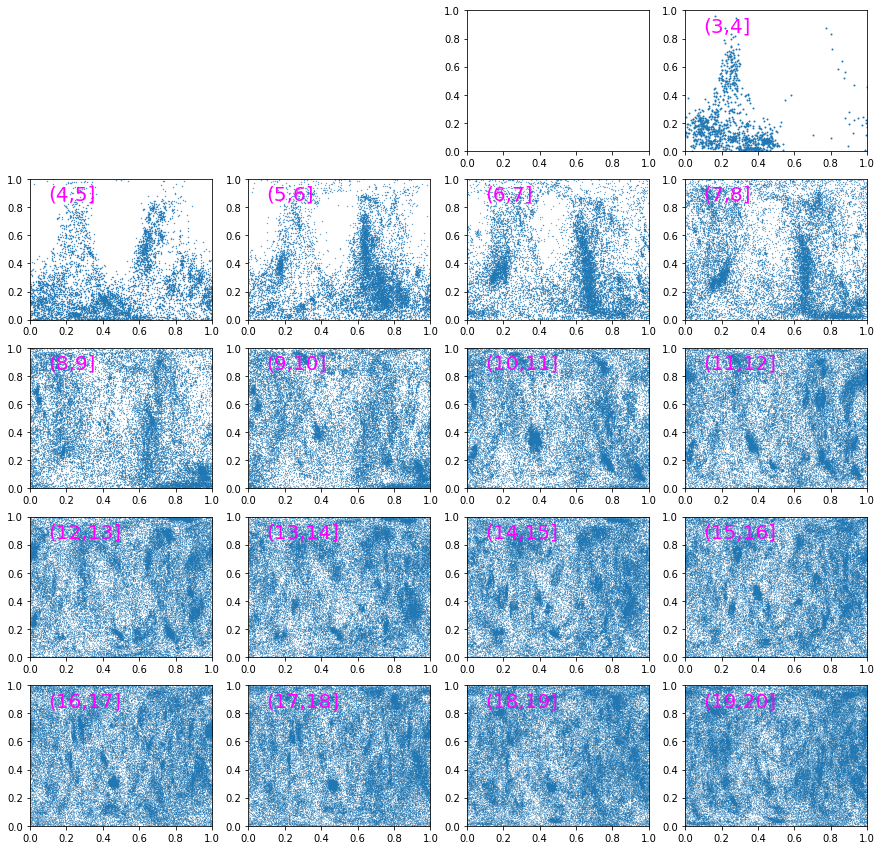

In [355]:
plot_for_pair(0, 0)


# Pair 0 - 1

Got 111801 values of 47916041 for pair 0 - 1
Distance (3;4]: 120 values bins [35 61  9 14  0  0  0  0  1] p-value 4.0785787719840377e-54
Distance (4;5]: 1089 values bins [143 115   9  82  93  21 334 126 166] p-value 1.0844025362150014e-124
Distance (5;6]: 2316 values bins [ 146   77   33  236   82  107 1210  246  179] p-value 0.0
Distance (6;7]: 2446 values bins [ 167  145   86  408  153  118 1028  200  141] p-value 0.0
Distance (7;8]: 2943 values bins [361 314 198 436 182 169 846 265 172] p-value 5.6883067255849064e-241
Distance (8;9]: 4030 values bins [487 451 351 522 367 230 854 388 380] p-value 2.6145060627411173e-112
Distance (9;10]: 4620 values bins [389 472 612 431 545 408 634 592 537] p-value 2.0342803791637236e-24
Distance (10;11]: 6333 values bins [ 388  582  841  429  609  589  704  838 1353] p-value 2.15831864542369e-200
Distance (11;12]: 6974 values bins [ 482  581  885  524  652  695  812  933 1410] p-value 1.0821705919296051e-175
Distance (12;13]: 7537 values bins [ 567 

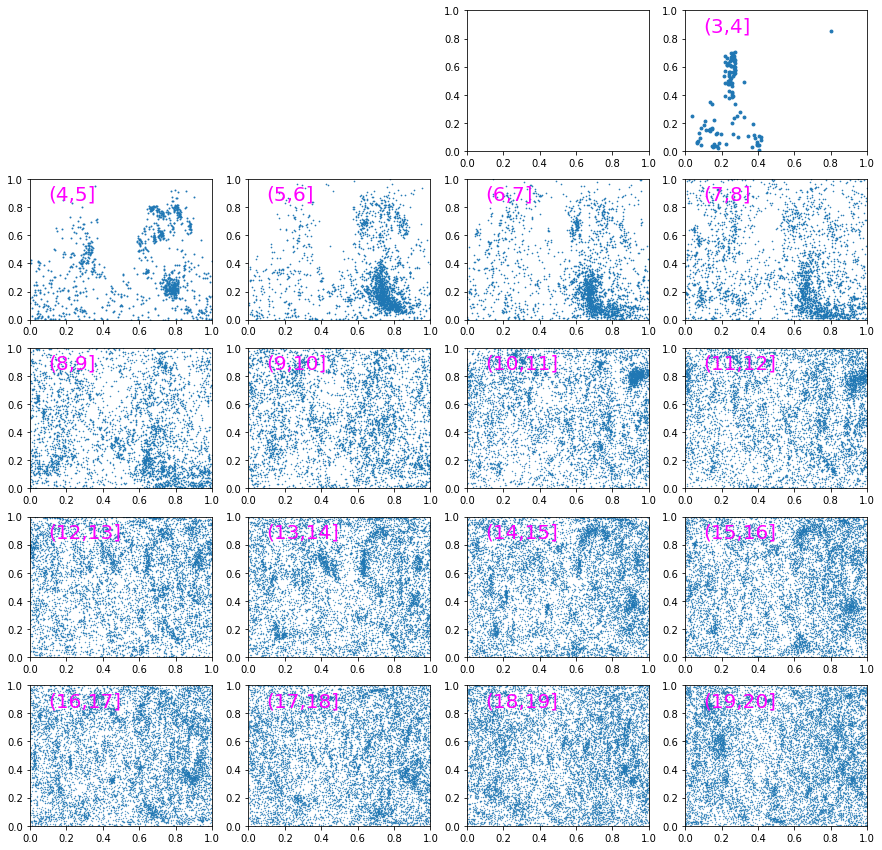

In [356]:
plot_for_pair(0, 1)

# Pair 0 - 2

Got 5449 values of 47916041 for pair 0 - 2
Distance (4;5]: 46 values bins [ 5  2  0 16  3  0 16  0  4] p-value 5.434613051957194e-11
Distance (5;6]: 124 values bins [ 3  2  0 28  4  5 51 28  3] p-value 2.2314830419724928e-35
Distance (6;7]: 94 values bins [ 6  5  5 25  4 10 23 13  3] p-value 1.1415781939494821e-08
Distance (7;8]: 140 values bins [21  9 21 19 10  2 31 16 11] p-value 8.146898036716403e-06
Distance (8;9]: 190 values bins [24 14 23 23 34 22 22 12 16] p-value 0.03904305710969516
Distance (9;10]: 225 values bins [23 19 23 10 50 17 24 30 29] p-value 3.203719780476998e-06
Distance (10;11]: 245 values bins [19  9 41 34 17 27 26 37 35] p-value 6.232259014435827e-05
Distance (11;12]: 285 values bins [22 16 37 33 26 22 18 45 66] p-value 6.464023451350384e-11
Distance (12;13]: 331 values bins [42 29 41 28 15 40 38 51 47] p-value 0.0008533778446853416
Distance (13;14]: 456 values bins [44 34 48 47 32 68 37 92 54] p-value 1.6479090304936692e-09
Distance (14;15]: 515 values bins [40 3

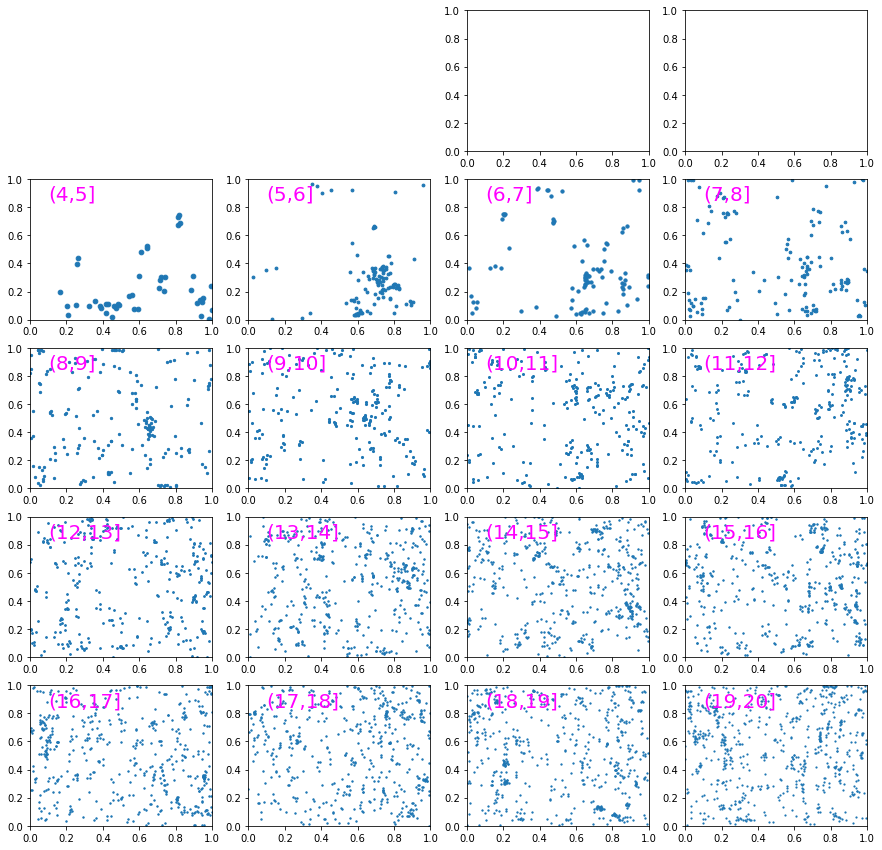

In [357]:
plot_for_pair(0, 2)

# Top uniform distributions

In [366]:
def get_uniformity_pvalue(data, a, b):
    data_local = data[np.where(
        (data[:, 0] == a) & (data[:, 1] == b)
    )][:, 3:]
    
    if data_local.shape[0] < 10:
        return 0, 0
        
    u, v = map_to_square(data_local[:,0], data_local[:,1])
    bins = map_to_bins(u, v, 3)
    #print(bins)
    chi_stat, dof = uniformity_chi_stat(bins)
    
    p_value = scipy.stats.chisquare(bins).pvalue
    print('Pair', a, b, ' num values', np.sum(bins), 'p-value:', p_value)
    
    return np.sum(bins), p_value

data_inf = data[np.where(
        (data[:, 2] > 19) & (data[:, 2] <= 20))]

top_p_values = []

for a in range(21):
    for b in range(40):
        num_values, p_value = get_uniformity_pvalue(data_inf, a, b)
        top_p_values.append((p_value, num_values, a, b))

top_p_values = sorted(top_p_values)[::-1]

Pair 0 0  num values 75734 p-value: 0.0
Pair 0 1  num values 12884 p-value: 1.1351100391548274e-110
Pair 0 2  num values 708 p-value: 2.9146996135179107e-06
Pair 0 3  num values 21830 p-value: 4.260263135455876e-73
Pair 0 4  num values 107782 p-value: 0.0
Pair 0 5  num values 5548 p-value: 8.921103449008145e-50
Pair 0 6  num values 1258 p-value: 8.667131254460602e-85
Pair 0 7  num values 6499 p-value: 6.824784041909843e-62
Pair 0 8  num values 10051 p-value: 9.147688255129813e-99
Pair 0 9  num values 857 p-value: 2.527536847428291e-12
Pair 0 10  num values 367 p-value: 3.059208413955825e-08
Pair 0 11  num values 220 p-value: 0.07170629010317084
Pair 0 12  num values 312 p-value: 0.004251046893143332
Pair 0 13  num values 20475 p-value: 1.9277966074114182e-113
Pair 0 14  num values 3302 p-value: 8.051737072502509e-38
Pair 0 15  num values 54 p-value: 0.02681932647449008
Pair 0 16  num values 384 p-value: 3.1241452217884875e-07
Pair 0 17  num values 69 p-value: 0.1760441985827135
Pair 0 

Pair 4 2  num values 164 p-value: 0.03386776091276335
Pair 4 3  num values 6857 p-value: 1.930805767290559e-93
Pair 4 4  num values 28872 p-value: 7.86599387284308e-301
Pair 4 5  num values 1234 p-value: 2.2606997665222384e-14
Pair 4 6  num values 402 p-value: 1.2169755697656749e-15
Pair 4 7  num values 1655 p-value: 5.1704718898587493e-14
Pair 4 8  num values 2945 p-value: 2.578813746635328e-22
Pair 4 9  num values 197 p-value: 2.8137312663398794e-08
Pair 4 10  num values 108 p-value: 5.6670492090214005e-06
Pair 4 11  num values 48 p-value: 0.12074571671871422
Pair 4 12  num values 58 p-value: 0.04926463170692952
Pair 4 13  num values 6229 p-value: 1.2877476835392746e-48
Pair 4 14  num values 1435 p-value: 3.039284821307173e-78
Pair 4 15  num values 43 p-value: 1.4862818465895007e-26
Pair 4 16  num values 72 p-value: 0.06419276770621928
Pair 4 17  num values 22 p-value: 0.17266566609655415
Pair 4 18  num values 142 p-value: 6.470472388494026e-07
Pair 4 19  num values 1244 p-value: 1.3

Pair 8 8  num values 3975 p-value: 1.2068197445220777e-47
Pair 8 9  num values 256 p-value: 7.162156305316446e-19
Pair 8 10  num values 159 p-value: 4.3741817191622907e-07
Pair 8 11  num values 77 p-value: 0.07461567987786122
Pair 8 12  num values 84 p-value: 6.158827246509181e-05
Pair 8 13  num values 7208 p-value: 5.346942082765518e-57
Pair 8 14  num values 1142 p-value: 8.172067485139075e-16
Pair 8 15  num values 36 p-value: 1.887061709863445e-15
Pair 8 16  num values 128 p-value: 0.004117657056181673
Pair 8 17  num values 22 p-value: 0.8403577761705645
Pair 8 18  num values 84 p-value: 0.0019415601451287132
Pair 8 19  num values 1426 p-value: 7.269546900824107e-07
Pair 8 20  num values 3469 p-value: 6.205916359741075e-32
Pair 8 21  num values 164 p-value: 0.00023691494026042468
Pair 8 22  num values 104 p-value: 0.0011328969141725215
Pair 8 23  num values 7847 p-value: 4.3900274897668766e-76
Pair 8 24  num values 5462 p-value: 2.7145989420358183e-59
Pair 8 25  num values 4314 p-val

Pair 12 12  num values 112 p-value: 2.393808618517574e-06
Pair 12 13  num values 7527 p-value: 7.810148410708286e-106
Pair 12 14  num values 1145 p-value: 6.553471309306884e-29
Pair 12 15  num values 19 p-value: 0.018282074318308587
Pair 12 16  num values 140 p-value: 1.2169711804374812e-09
Pair 12 17  num values 37 p-value: 0.38744589819070224
Pair 12 18  num values 191 p-value: 2.2367140147796506e-14
Pair 12 19  num values 1770 p-value: 9.57471204126401e-08
Pair 12 20  num values 3823 p-value: 7.177466487957167e-47
Pair 12 21  num values 145 p-value: 0.028227482490457995
Pair 12 22  num values 89 p-value: 0.00010801132408759092
Pair 12 23  num values 8036 p-value: 1.0993499673902434e-121
Pair 12 24  num values 5846 p-value: 7.644162946938297e-121
Pair 12 25  num values 4848 p-value: 4.4376304076396235e-66
Pair 12 26  num values 158 p-value: 0.0020578447114467584
Pair 12 27  num values 330 p-value: 0.0002946220656639252
Pair 12 28  num values 419 p-value: 7.538919032953946e-34
Pair 12

Pair 16 11  num values 191 p-value: 0.008235073293576993
Pair 16 12  num values 277 p-value: 4.000509784578835e-09
Pair 16 13  num values 18904 p-value: 0.0
Pair 16 14  num values 2722 p-value: 1.78578033278207e-44
Pair 16 15  num values 21 p-value: 0.11686031410126066
Pair 16 16  num values 278 p-value: 0.014517182709368482
Pair 16 17  num values 50 p-value: 6.6913291787569e-05
Pair 16 18  num values 377 p-value: 5.610055591831615e-49
Pair 16 19  num values 3468 p-value: 1.0427863456253838e-70
Pair 16 20  num values 9055 p-value: 6.023264144390355e-185
Pair 16 21  num values 340 p-value: 1.6063271911088314e-07
Pair 16 22  num values 298 p-value: 8.060481582045767e-11
Pair 16 23  num values 19373 p-value: 0.0
Pair 16 24  num values 13167 p-value: 5.144703679082275e-136
Pair 16 25  num values 10692 p-value: 3.067239474083626e-110
Pair 16 26  num values 340 p-value: 0.002008469606578404
Pair 16 27  num values 1047 p-value: 4.798206118854926e-15
Pair 16 28  num values 781 p-value: 4.71309

Pair 20 35  num values 390 p-value: 0.08970971680466389
Pair 20 36  num values 170 p-value: 0.0021309938843362187
Pair 20 37  num values 10 p-value: 0.8193524217033382
Pair 20 38  num values 10 p-value: 0.6248399453990456


In [369]:
top_p_values_with_many_points = [t for t in top_p_values if t[1] > 500]

for t in top_p_values_with_many_points[:10]:
    print(t)

(0.005289038550617875, 1790, 20, 34)
(0.0003667729609617166, 1220, 20, 27)
(1.4303682661028368e-05, 1004, 15, 27)
(4.101004012022975e-06, 1336, 0, 27)
(3.6692883577568982e-06, 556, 18, 9)
(3.4061003846108764e-06, 504, 10, 16)
(2.9146996135179107e-06, 708, 0, 2)
(7.269546900824107e-07, 1426, 8, 19)
(7.084211169632459e-07, 575, 7, 2)
(1.1937776607717386e-07, 902, 10, 2)


# Pair 20 - 34

Got 18410 values of 47916041 for pair 20 - 34
Distance (3;4]: 23 values bins [14  1  6  2  0  0  0  0  0] p-value 5.538568873780782e-12
Distance (4;5]: 251 values bins [ 18  17  32 118   9   0  10  23  24] p-value 1.9968691170778083e-71
Distance (5;6]: 362 values bins [ 37  19  22  77  38   6 110  48   5] p-value 1.6088336692759907e-46
Distance (6;7]: 525 values bins [ 54  30  38  97  22  20 185  43  36] p-value 1.1689544502783199e-77
Distance (7;8]: 573 values bins [ 71  36  82  52 105  35 127  27  38] p-value 2.264162474369487e-29
Distance (8;9]: 919 values bins [ 78  89 123  82 132  73 231  40  71] p-value 6.350001042574365e-48
Distance (9;10]: 1096 values bins [ 91  95 150 130  88 117 236 119  70] p-value 2.002742572472768e-30
Distance (10;11]: 1129 values bins [ 77 139 137 144 155  90 114 128 145] p-value 3.514516518135268e-07
Distance (11;12]: 1158 values bins [ 86 129 101 109 180 122 133 191 107] p-value 1.2793312100581377e-13
Distance (12;13]: 1370 values bins [161 144 241  86 

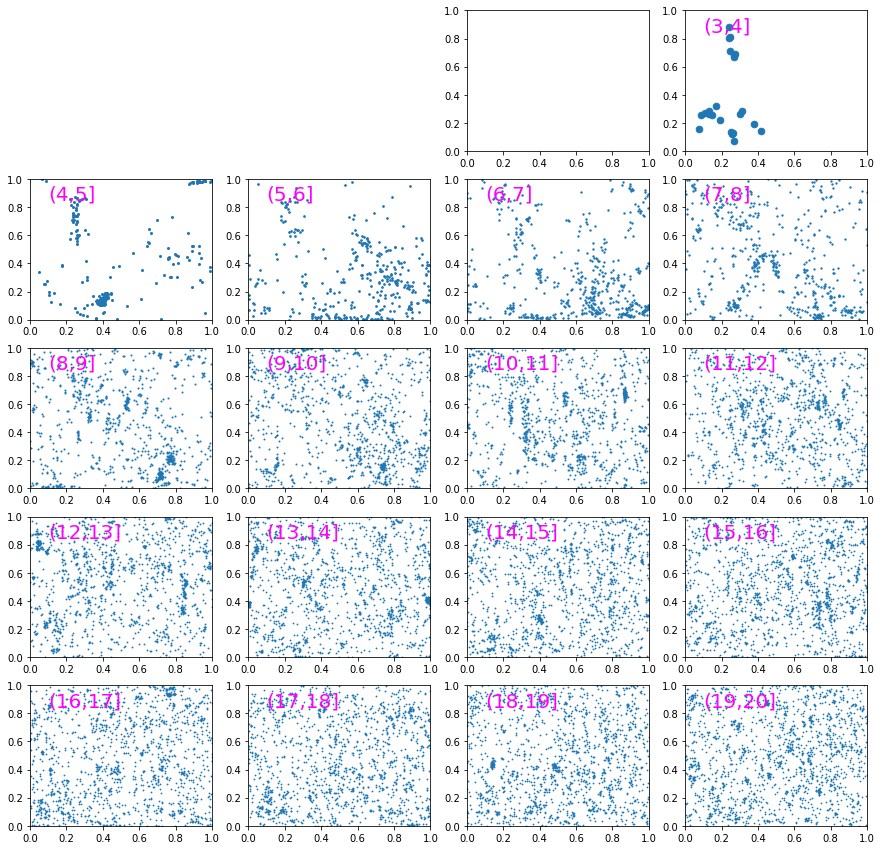

In [370]:
plot_for_pair(20, 34)

# Pair 20 - 27

Got 11622 values of 47916041 for pair 20 - 27
Distance (4;5]: 26 values bins [9 0 3 3 0 8 0 2 1] p-value 8.741302365047071e-05
Distance (5;6]: 98 values bins [ 8  4  6 13  9  1 36 18  3] p-value 4.155251752432118e-15
Distance (6;7]: 201 values bins [ 9  6 12 28 14 10 90 14 18] p-value 1.962000784583391e-48
Distance (7;8]: 264 values bins [17  6 53 33 21 10 55 33 36] p-value 1.3080810069791228e-14
Distance (8;9]: 419 values bins [36 52 55 39 34 20 93 68 22] p-value 9.104121135070482e-17
Distance (9;10]: 459 values bins [49 49 64 40 52 38 88 54 25] p-value 5.209677051564535e-08
Distance (10;11]: 664 values bins [53 44 61 79 85 78 95 86 83] p-value 0.00010610428518156505
Distance (11;12]: 646 values bins [ 60  61  69  62 111 100  80  49  54] p-value 3.9221888922880304e-08
Distance (12;13]: 903 values bins [ 72  93 107 106 114  95 110 101 105] p-value 0.12644986935573344
Distance (13;14]: 989 values bins [107 104  65  98 127  97 125 115 151] p-value 1.4221491222924934e-06
Distance (14;15]:

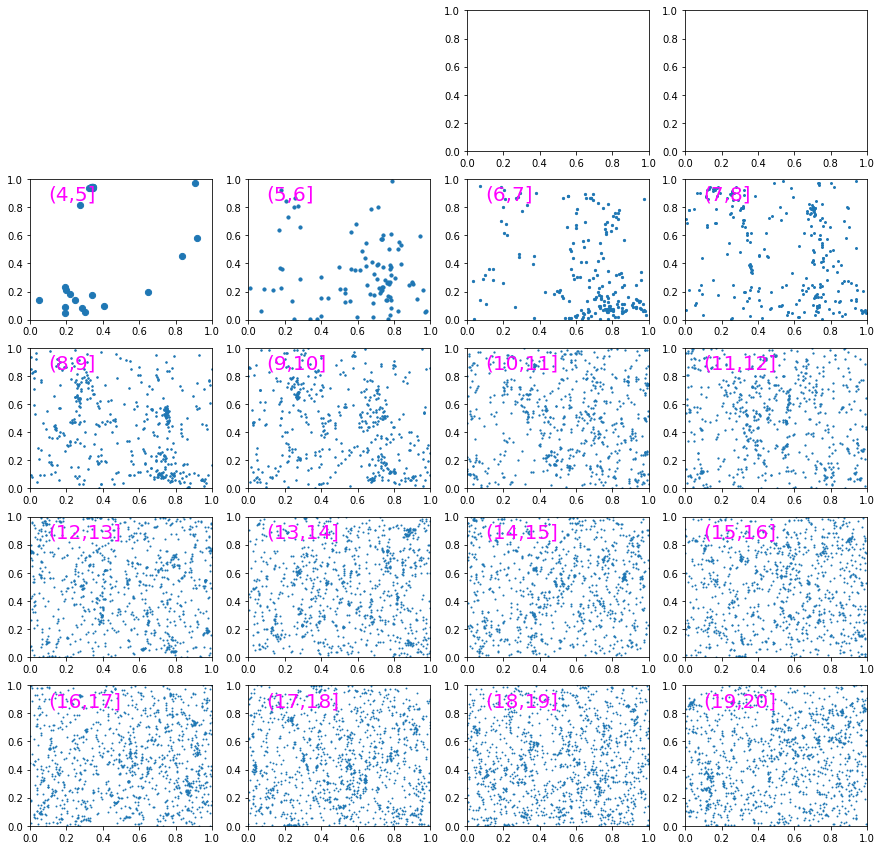

In [371]:
plot_for_pair(20, 27)

# Pair 15 - 27

Got 9576 values of 47916041 for pair 15 - 27
Distance (4;5]: 38 values bins [ 9  1  1 10  5  0  8  4  0] p-value 0.00019400795654445085
Distance (5;6]: 90 values bins [11  1  5  7 11  2 31 20  2] p-value 9.349867988736508e-14
Distance (6;7]: 108 values bins [11 12  8  5  5  9 38 17  3] p-value 3.916777449157565e-13
Distance (7;8]: 291 values bins [43 32 31 30 25 39 45 26 20] p-value 0.023668554283556218
Distance (8;9]: 377 values bins [34 37 40 20 30 51 69 64 32] p-value 3.292547829853806e-08
Distance (9;10]: 508 values bins [26 44 67 34 89 42 74 66 66] p-value 2.669825195423574e-10
Distance (10;11]: 500 values bins [57 49 40 33 70 54 67 75 55] p-value 0.0006294014400336462
Distance (11;12]: 673 values bins [ 53  57  91  61  73  53  96 116  73] p-value 1.8388558697389468e-08
Distance (12;13]: 770 values bins [ 63  56  85  56 101  80 117  94 118] p-value 6.277017168426747e-09
Distance (13;14]: 790 values bins [ 77  79  71  78 111  80  71 138  85] p-value 3.145382231731858e-07
Distance (

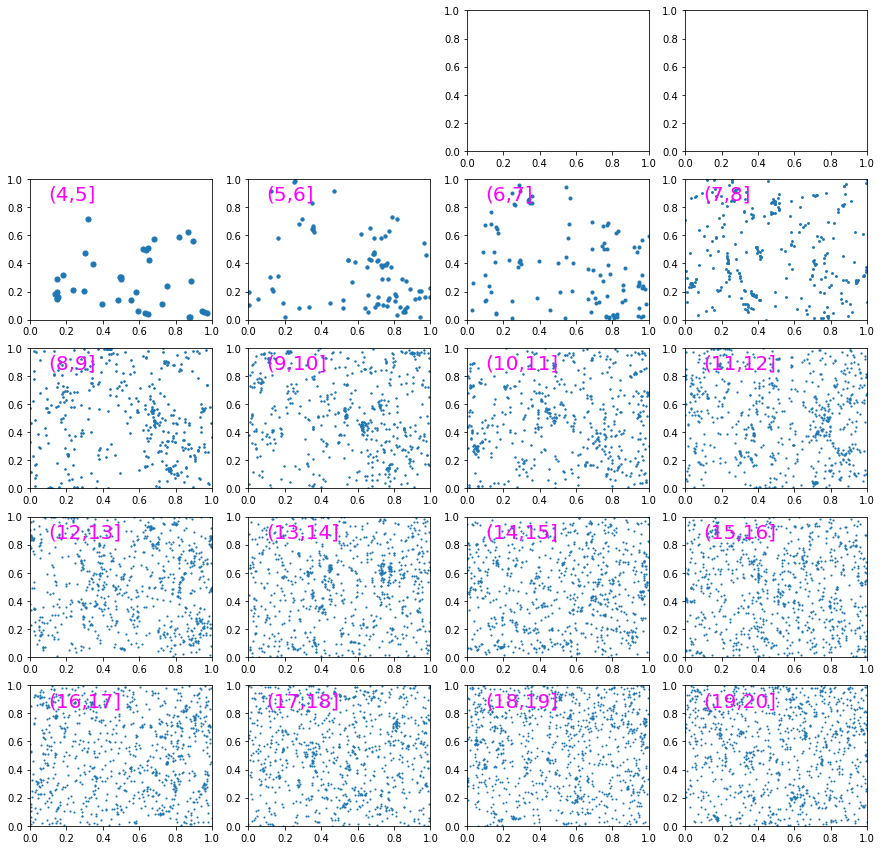

In [372]:
plot_for_pair(15, 27)

# More pictures for pair 0 - 1

(954266, 3)
(954266, 3)
[55888 57888 58298 56456 50067 53667 44960 51931 61898 62007 63776 59311
 64779 76810 72035 64495]
p-value (~ probability is uniform): 0.0
Power_divergenceResult(statistic=16057.194715100402, pvalue=0.0)

is uniform (strict): no


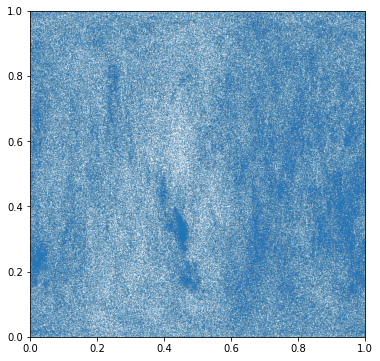

(932749, 3)
[51522 55911 57980 56258 46688 52405 44460 51607 60185 60208 62866 58823
 62967 75607 71259 64003]
p-value (~ probability is uniform): 0.0
Power_divergenceResult(statistic=17358.421207634638, pvalue=0.0)

is uniform (strict): no


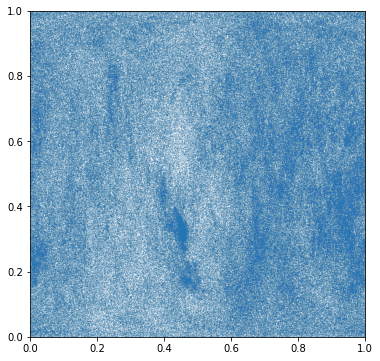

(824992, 3)
[44243 48041 51463 50935 40931 46537 40241 47491 50441 51246 55732 52746
 52005 68473 65269 59198]
p-value (~ probability is uniform): 0.0
Power_divergenceResult(statistic=17491.384507970986, pvalue=0.0)

is uniform (strict): no


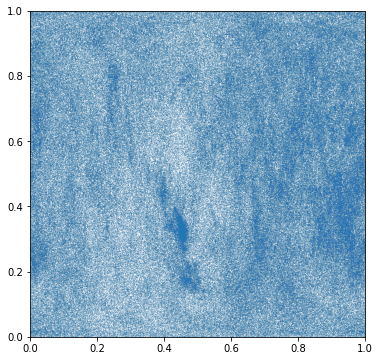

(566304, 3)
[31650 32241 34829 34658 28178 29800 28159 31485 34698 36580 38822 35130
 35235 47006 46226 41607]
p-value (~ probability is uniform): 0.0
Power_divergenceResult(statistic=13570.610103407358, pvalue=0.0)

is uniform (strict): no


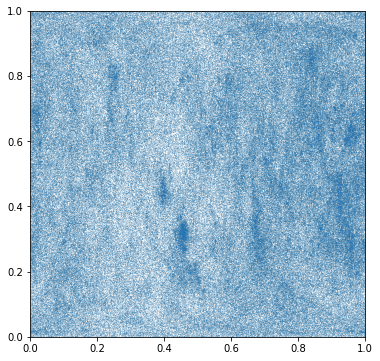

(210515, 3)
[11901 12485 13281 13227 10418  9338  9640 10660 13132 15118 14848 12655
 12785 17520 17768 15739]
p-value (~ probability is uniform): 0.0
Power_divergenceResult(statistic=7357.226188157613, pvalue=0.0)

is uniform (strict): no


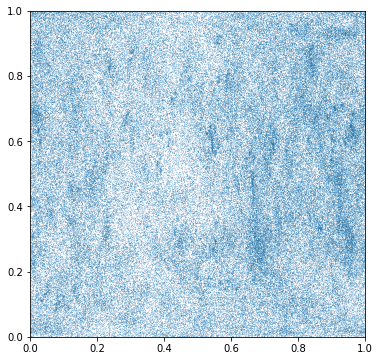

In [302]:
print(data_local.shape)

for d in range(2, 20, 4):
    data_dist = data_local[data_local[:,0] > d][:,:]
    print(data_dist.shape)

    u, v = map_to_square(data_dist[:,1], data_dist[:,2])
    bins = map_to_bins(u, v, 4)
    print(bins)
    chi_stat, dof = uniformity_chi_stat(bins)

    p_value = 1 - chi2.cdf(chi_stat, dof)
    print('p-value (~ probability is uniform):', p_value)
    print(scipy.stats.chisquare(bins))
    print()
    print('is uniform (strict):', ('yes' if p_value > 0.01 else 'no'))

    plot_square(u, v)